In [1]:
#!pip install yfinance pandas numpy requests matplotlib seaborn plotly statsmodels scikit-learn xgboost

C:\Users\ASUS\Projects\Projectpy\notebooks\../utils\data_fetcher.py:81: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


Downloaded 1410 Henry Hub price records
Note: Using simplified weather data generation
For production, consider using OpenWeatherMap API or NOAA data
Generating demo storage data...


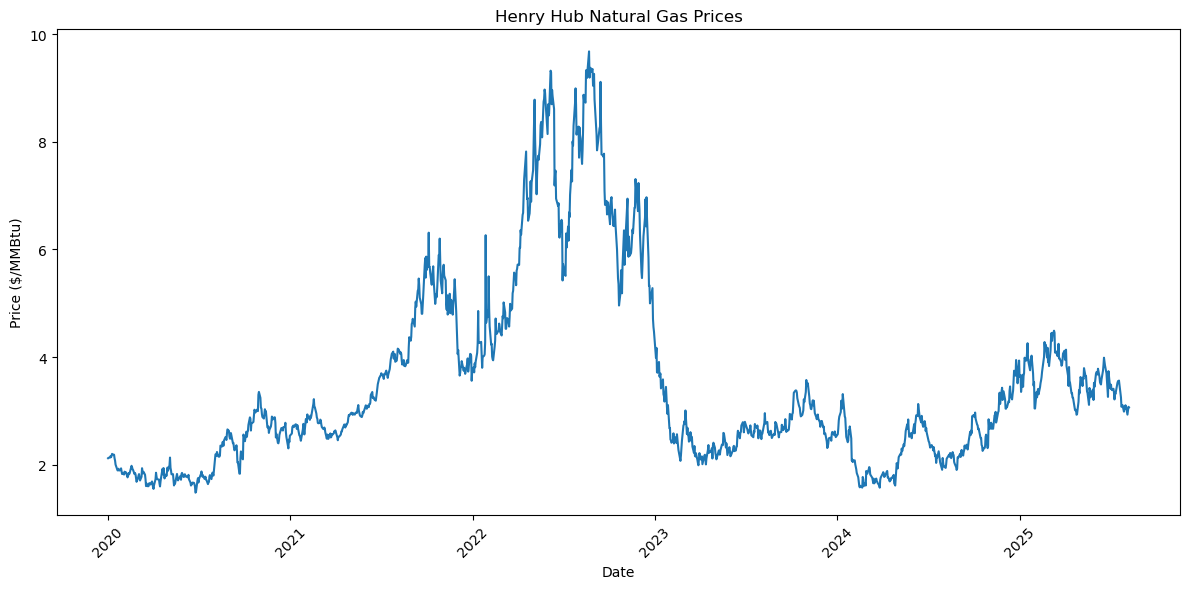

Price data: 1410 records
Date range: 2020-01-02 00:00:00 to 2025-08-07 00:00:00


In [3]:
import sys
sys.path.append('../utils')

from data_fetcher import NaturalGasDataFetcher
import pandas as pd
import matplotlib.pyplot as plt

fetcher = NaturalGasDataFetcher(eia_api_key="oFFfwEonZjh6oENLFfK0XBHeH7nUUcCb0YJh0LJx")

prices = fetcher.get_henry_hub_prices()
weather = fetcher.get_weather_data()

# Use demo storage data
storage = fetcher._generate_demo_data()  # This generates realistic demo data

if prices is not None:
    # Simple analysis with price data
    plt.figure(figsize=(12, 6))
    plt.plot(prices['date'], prices['henry_hub_price'])
    plt.title('Henry Hub Natural Gas Prices')
    plt.xlabel('Date')
    plt.ylabel('Price ($/MMBtu)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    print(f"Price data: {prices.shape[0]} records")
    print(f"Date range: {prices['date'].min()} to {prices['date'].max()}")

In [5]:
print("=== HENRY HUB PRICES ===")
if prices is not None:
    print(f"Shape: {prices.shape}")
    print(f"Columns: {list(prices.columns)}")
    print(prices.head())

print("\n=== STORAGE DATA ===")
storage = fetcher.get_storage_data()
if storage is not None:
    print(f"Shape: {storage.shape}")
    print(f"Columns: {list(storage.columns)}")
    print(storage.head())

print("\n=== WEATHER DATA ===") 
if weather is not None:
    print(f"Shape: {weather.shape}")
    print(f"Columns: {list(weather.columns)}")
    print(weather.head())

=== HENRY HUB PRICES ===
Shape: (1410, 2)
Columns: [('date', ''), ('henry_hub_price', 'NG=F')]
Price        date henry_hub_price
Ticker                       NG=F
0      2020-01-02           2.122
1      2020-01-03           2.130
2      2020-01-06           2.135
3      2020-01-07           2.162
4      2020-01-08           2.141

=== STORAGE DATA ===
No data found in API response

=== WEATHER DATA ===
Shape: (1461, 4)
Columns: ['date', 'temperature', 'hdd', 'cdd']
                        date  temperature  hdd        cdd
0 2021-08-09 14:57:16.761994    76.205402  0.0  11.205402
1 2021-08-10 14:57:16.761994    68.870002  0.0   3.870002
2 2021-08-11 14:57:16.761994    71.521237  0.0   6.521237
3 2021-08-12 14:57:16.761994    85.928098  0.0  20.928098
4 2021-08-13 14:57:16.761994    67.500451  0.0   2.500451


In [7]:
# If the DataFrame has multi-level columns
if isinstance(prices.columns, pd.MultiIndex):
    prices.columns = ['_'.join(col).strip() if col[1] else col[0] for col in prices.columns.values]

In [9]:
prices = prices.rename(columns={'henry_hub_price_NG=F': 'price'})

In [11]:
prices['date'] = pd.to_datetime(prices['date']).dt.date
weather['date'] = pd.to_datetime(weather['date']).dt.date

In [13]:
start_date = weather['date'].min()
prices = prices[prices['date'] >= start_date]

In [15]:
print(prices.isna().sum())
print(weather.isna().sum())

date     0
price    0
dtype: int64
date           0
temperature    0
hdd            0
cdd            0
dtype: int64


In [17]:
prices['price'] = prices['price'].astype(float)
prices.head()

,date,price
403,2021-08-09,4.060
404,2021-08-10,4.089
405,2021-08-11,4.059
406,2021-08-12,3.933
407,2021-08-13,3.861


In [19]:
weather.head()

,date,temperature,hdd,cdd
0,2021-08-09,76.205402,0.0,11.205402
1,2021-08-10,68.870002,0.0,3.870002
2,2021-08-11,71.521237,0.0,6.521237
3,2021-08-12,85.928098,0.0,20.928098
4,2021-08-13,67.500451,0.0,2.500451


In [21]:
full_range = pd.DataFrame({'date': pd.date_range(
    start=min(prices['date'].min(), weather['date'].min()),
    end=max(prices['date'].max(), weather['date'].max()),
    freq='D'
).date})

In [23]:
# Merge the datasets on date
df = full_range.merge(prices, on='date', how='left')
df = df.merge( weather, on='date', how='left')

# Sort by date
df = df.sort_values('date')

# Reset index
df.reset_index(drop=True, inplace=True)

# Final shape and preview
print(df.shape)
print(df.head())

(1461, 5)
         date  price  temperature  hdd        cdd
0  2021-08-09  4.060    76.205402  0.0  11.205402
1  2021-08-10  4.089    68.870002  0.0   3.870002
2  2021-08-11  4.059    71.521237  0.0   6.521237
3  2021-08-12  3.933    85.928098  0.0  20.928098
4  2021-08-13  3.861    67.500451  0.0   2.500451


In [25]:
# Fill missing values
df['price'] = df['price'].ffill().bfill()
df['temperature'] = df['temperature'].interpolate()
df['hdd'] = df['hdd'].interpolate()
df['cdd'] = df['cdd'].interpolate()

In [27]:
print(df.head(30))

          date  price  temperature        hdd        cdd
0   2021-08-09  4.060    76.205402   0.000000  11.205402
1   2021-08-10  4.089    68.870002   0.000000   3.870002
2   2021-08-11  4.059    71.521237   0.000000   6.521237
3   2021-08-12  3.933    85.928098   0.000000  20.928098
4   2021-08-13  3.861    67.500451   0.000000   2.500451
5   2021-08-14  3.861    66.067553   0.000000   1.067553
6   2021-08-15  3.861    79.607108   0.000000  14.607108
7   2021-08-16  3.946    50.256624  14.743376   0.000000
8   2021-08-17  3.837    69.297325   0.000000   4.297325
9   2021-08-18  3.852    77.415088   0.000000  12.415088
10  2021-08-19  3.830    60.082210   4.917790   0.000000
11  2021-08-20  3.851    76.282663   0.000000  11.282663
12  2021-08-21  3.851    68.059860   0.000000   3.059860
13  2021-08-22  3.851    61.649680   3.350320   0.000000
14  2021-08-23  3.945    49.019463  15.980537   0.000000
15  2021-08-24  3.896    81.496703   0.000000  16.496703
16  2021-08-25  3.897    63.439

In [29]:
df.to_csv("../data/processed_natural_gas_data.csv", index=False)

In [31]:
from pandas.tseries.offsets import Day

expected_dates = pd.date_range(df['date'].min(), df['date'].max(), freq=Day())
missing_dates = set(expected_dates.date) - set(df['date'])
print("Missing dates:", missing_dates)

Missing dates: set()
